<a href="https://colab.research.google.com/github/ugoetudo/valenced-rel-extraction/blob/main/ValencedRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from transformers import AutoTokenizer, TFRobertaModel
import tensorflow as tf
# from tensorflow import keras
import keras
from keras import regularizers
from tqdm import tqdm
from tqdm.auto import tqdm
from keras import layers
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_relations = pd.read_csv("/content/drive/MyDrive/Colab Data/relation_extraction_data/7_31_921_all_relations.csv")

### **Eliminate Overlapping Codes**

In [ ]:
def get_first(x):
    return x.iloc[0]

overlap_check = all_relations.groupby(["sid", "lefttkids",
                                       "righttkids", "sentence_text",
                                       "left_entity", "lefttext",
                                       "right_entity", "righttext",])\
                                       .agg({"Relation": get_first,
                                             "Valence": get_first})
overlap_check.reset_index(inplace=True)
overlap_check.head(200)

,sid,lefttkids,righttkids,sentence_text,left_entity,lefttext,right_entity,righttext,Relation,Valence
0,1000.0,0,1 1,"Hale had chosen Reardon , he said Reardon had ...",Person,Hale,Critical Infrastructure,law,NaN,NaN
1,1000.0,0,1 2,"Hale had chosen Reardon , he said Reardon had ...",Person,Hale,Critical Infrastructure,school,NaN,NaN
2,1000.0,0,1 5,"Hale had chosen Reardon , he said Reardon had ...",Person,Hale,Person,Hale,NaN,NaN
3,1000.0,0,3,"Hale had chosen Reardon , he said Reardon had ...",Person,Hale,Person,Reardon,NaN,NaN
4,1000.0,0,7,"Hale had chosen Reardon , he said Reardon had ...",Person,Hale,Person,Reardon,Moves For,Neutral
...,...,...,...,...,...,...,...,...,...,...
195,1006.0,77 | 78,7 7 | 7 8,We agreed that most of us who have become Whit...,Person,Talmud | Tubes,Person,Talmud | Tubes,NaN,NaN
196,1006.0,77 | 78,7 8,We agreed that most of us who have become Whit...,Person,Talmud | Tubes,Person,Tubes,NaN,NaN
197,1006.0,77 | 78,9,We agreed that most of us who have become Whit...,Person,Talmud | Tubes,Ideologue,White,NaN,NaN
198,1006.0,77 | 78,9 | 1 0,We agreed that most of us who have become Whit...,Person,Talmud | Tubes,People | Value,White | racialists,NaN,NaN


In [ ]:
all_relations = overlap_check.copy()

In [ ]:
pd.options.display.max_rows = 300
pd.options.display.max_columns = 50

In [ ]:
all_relations.loc[all_relations['Relation'].isna(), 'Relation'] = "none"
all_relations.loc[all_relations['Valence'].isna(), 'Valence'] = "none"
# all_relations['Valence'].head(100)

In [ ]:
def pad_text(entity: list, max_length: int = 5, pad_char: str = "0"):
  if len(entity) > max_length:
    return entity[:max_length]
  else:
    return entity + [pad_char] * (max_length - len(entity))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base", add_prefix_space=True)
MAX_ENTITY_LENGTH = 5
MAX_SENTENCE_LEN = 100

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def build_entity_input(entity_text, tokenizer):
  tokenized_entity = tokenizer(pad_text(entity_text, MAX_ENTITY_LENGTH),
                               truncation=True,
                               padding=True,
                               return_tensors="tf")
  input_ids = tokenized_entity["input_ids"]
  attention_mask = tokenized_entity["attention_mask"]
  return input_ids, attention_mask
'''
def build_sentence_input(sentence_text):
  tokenized_sentence = tokenizer(sentence_text,
                                 max_length=MAX_SENTENCE_LEN,
                                 truncation=True,
                                 padding=True,
                                 is_split_into_words=True,
                                 return_tensors="tf",
                                 )
  # input_ids = tokenized_sentence["input_ids"]
  # attention_mask = tokenized_sentence["attention_mask"]
  return tokenized_sentence
'''
def build_sentence_input(sentence_text):
  tokenized_sentence = tokenizer(sentence_text,
                                 max_length=MAX_SENTENCE_LEN,
                                 truncation=True,
                                 padding="max_length",
                                 is_split_into_words=True,
                                 return_tensors="tf"
                                 )
  # input_ids = tokenized_sentence["input_ids"]
  # attention_mask = tokenized_sentence["attention_mask"]
  return tokenized_sentence


In [ ]:
# samples a fraction of negative cases
def downsample(df, classname, col, sample_rate):
  class_df = df.loc[df[col] == classname]
  nonclass_df = df.loc[df[col] != classname]
  class_df = class_df.sample(frac=sample_rate)
  return pd.concat([class_df, nonclass_df])

print("before downsampling: ", str(all_relations.shape))
all_relations = downsample(all_relations, "Neutral", "Valence", 0.5)
all_relations = downsample(all_relations, "none", "Relation", 0.07)
all_relations = downsample(all_relations, "Present", "Relation", 0.5)
print("after downsampling: ", str(all_relations.shape))


before downsampling:  (85313, 10)
after downsampling:  (11478, 10)


In [ ]:
all_relations.loc[all_relations['Relation'] == 'is', 'Relation'] = 'Is'
all_relations.loc[all_relations['Relation'] == 'Mil. Tactic', 'Relation'] = 'Mil.Tactic'
all_relations.loc[all_relations['Relation'] == 'Moves For', 'Relation'] = 'MovesFor'
all_relations.loc[all_relations['Relation'] == 'Moves Back', 'Relation'] = 'MovesBack'
all_relations.loc[all_relations['Relation'] == 'MovesBack', 'Relation'] = 'Opposes'
all_relations.loc[all_relations['Relation'] == 'Is Not', 'Relation'] = 'IsNot'
all_relations.loc[all_relations['Relation'] == 'Feels Pos', 'Relation'] = 'FeelsPos'
all_relations.loc[all_relations['Relation'] == 'Feels Neg', 'Relation'] = 'FeelsNeg'
all_relations.loc[all_relations['Relation'] == 'FeelsNeg', 'Relation'] = 'Opposes'
# all_relations.loc[all_relations['Relation'] == 'Belongs', 'Relation'] = 'Present'

In [ ]:
relation_counts = all_relations["Relation"].value_counts().reset_index()
relation_counts.columns = ["Relation", "Count"]
exrels = relation_counts.loc[relation_counts['Count'] >= 100, 'Relation'].tolist()

In [ ]:
all_relations = all_relations.loc[(all_relations['Relation'].isin(exrels)) &
                                  ~(all_relations['Valence']).isin(['Extremely Negative', 'Extremely Positive']), :]


In [ ]:
def get_targets_from_df(df: pd.DataFrame):
  targets = pd.unique(df['Relation']).tolist()
  target_encoding = {target: i for i, target in enumerate(targets)}
  return target_encoding


targets = get_targets_from_df(all_relations)
targets.keys()

dict_keys(['Present', 'none', 'Belongs', 'Is', 'Agrees', 'Caused', 'MovesFor', 'Opposes', 'Informs', 'Thinks', 'Harms', 'Kills', 'Influences', 'IsNot', 'Obtains', 'Disagrees', 'Cooperates', 'Threat'])

In [ ]:
def get_valence_targets(df: pd.DataFrame):
  v_targets = pd.unique(df['Valence']).tolist()
  v_target_encoding = {v_target: i for i, v_target in enumerate(v_targets)}
  return v_target_encoding

valence_targets = get_valence_targets(all_relations)
valence_targets.keys()

dict_keys(['Negative', 'Neutral', 'Positive', 'none'])

In [ ]:
lei = all_relations['left_entity'].str.split("|", n=1, expand=True)[0]
rei = all_relations['right_entity'].str.split("|", n=1, expand=True)[0]
all_relations['c_left_entity'] = lei
all_relations['c_right_entity'] = rei
entity_list = pd.unique(pd.concat([lei, rei]))
entity_lookup = {v:k for k,v in enumerate(entity_list)}

In [ ]:
# import json
# with open("/content/drive/MyDrive/Colab Data/entity_lookup_rels.json", "w") as f:
#   json.dump(entity_lookup, f)
# entity_lookup

In [ ]:
s_all_relations = all_relations.copy()
print("before empty sentences: ", str(s_all_relations.shape))
s_all_relations = s_all_relations.loc[~s_all_relations['left_entity'].isna(), :]
print("after empty sentences: ", str(s_all_relations.shape))
s_all_relations["sentence_text"] = s_all_relations["sentence_text"].str.split(" ")

before empty sentences:  (10934, 12)
after empty sentences:  (10934, 12)


In [ ]:
def make_pos_embs_l(x):
  entity_vec = np.zeros(MAX_SENTENCE_LEN)
  tkids = str(x['lefttkids']).replace(" ", "").split("|")
  tkids = [int(tk) for tk in tkids]
  entity_vec[tkids] = entity_vec[tkids] + entity_lookup[x['c_left_entity']]
  entity_vec[0] = 1 #encodes the left or the right
  return entity_vec

def make_pos_embs_r(x):
  entity_vec = np.zeros(MAX_SENTENCE_LEN)
  tkids = str(x['righttkids']).replace(" ", "").split("|")
  tkids = [int(tk) for tk in tkids]
  entity_vec[tkids] = entity_vec[tkids] + entity_lookup[x['c_right_entity']]
  entity_vec[0] = 2 #encodes the left or the right
  return entity_vec

def get_entity_start_l(x):
  tkids = str(x['lefttkids']).replace(" ", "").split("|")
  tkids = [int(tk) for tk in tkids]
  rtkids = str(x['righttkids']).replace(" ", "").split("|")
  rtkids = [int(tk) for tk in rtkids]
  if rtkids[0] > tkids[0]:
    return tkids[0]
  else:
    return tkids[-1]

def get_entity_start_r(x):
  tkids = str(x['righttkids']).replace(" ", "").split("|")
  tkids = [int(tk) for tk in tkids]
  ltkids = str(x['lefttkids']).replace(" ", "").split("|")
  ltkids = [int(tk) for tk in ltkids]
  if ltkids[0] > tkids[0]:
    return tkids[0]
  else:
    return tkids[-1]

def slice_sentence(x):
  ls = x["l_entity_start"]
  rs = x["r_entity_start"]
  if rs > ls:
    s_slice = x["sentence_text"][ls:rs]
  else:
    s_slice = x["sentence_text"][rs:ls]
    reverse_sequence = s_slice[::-1]
    s_slice = reverse_sequence
  return s_slice


In [ ]:
aa = [1,2,3]
aa[::-1]

[3, 2, 1]

In [ ]:
s_all_relations['num_tokens'] = s_all_relations['sentence_text'].apply(len)

In [ ]:
s_all_relations = s_all_relations.loc[~s_all_relations['lefttkids'].isna(), :]
s_all_relations = s_all_relations.loc[~s_all_relations['righttkids'].isna(), :]

In [ ]:
s_all_relations = s_all_relations.loc[s_all_relations['num_tokens'] <= MAX_SENTENCE_LEN, :]
s_all_relations["l_pos_embs"] = s_all_relations.apply(make_pos_embs_l, axis=1)
s_all_relations["r_pos_embs"] = s_all_relations.apply(make_pos_embs_r, axis=1)
s_all_relations["l_entity_start"] = s_all_relations.apply(get_entity_start_l, axis=1)
s_all_relations["r_entity_start"] = s_all_relations.apply(get_entity_start_r, axis=1)
s_all_relations["inner_context"] = s_all_relations.apply(slice_sentence, axis=1)

In [ ]:
s_all_relations[["inner_context", "righttkids", "lefttkids", "sentence_text"]].head(100)

,inner_context,righttkids,lefttkids,sentence_text
11972,"[lesbian, and, homosexual, academicians, in, t...",7,1,"[The, lesbian, and, homosexual, academicians, ..."
28229,"[Sudanese, refugees, in, Kenya, ,, or]",2 8,22 | 23,"[If, people, absolutely, have, to, support, no..."
25195,"[greeks, in]",1 0,8,"[And, who, did, nt, want, your, non, white, gr..."
43070,"[,, Latvians, ,, Romanians, ,, Bulgarians, ,, ...",4 9 | 5 0 | 5 1,29,"[Well, Done, !, \n, \n, Remember, the, Jewish,..."
24594,"[US, three, including, ,, people, nine, killed...",1 9,26 | 27,"[On, Tuesday, night, ,, a, Taliban, attack, on..."
57361,"[Negroid, female, in, Michigan, or]",1 3,8,"[Then, a, few, years, before, there, was, a, N..."
6195,"[prayer, hall, ,, in, Dog, Kennel, Lane, ,]",2 1 | 2 2 | 2 3 | 2 4 | 2 5,17 | 18,"[Now, the, group, has, applied, for, planning,..."
45965,"[wheels, -, on, -, meals]",2 3,25 | 26 | 27 | 28,"[Members, of, that, , , vulnerable, , , Asian,..."
69930,"[,, Stormfront]",6,8,"[Always, great, to, have, you, on, Stormfront,..."
55320,"[white, people, in]",8,5 | 6,"[It, will, be, interesting, if, white, people,..."


In [ ]:
s_all_relations['rel_target'] = s_all_relations['Relation'].map(targets)

In [ ]:
from transformers import TFBertModel

In [ ]:

# @keras.saving.register_keras_serializable()
class bertModelValence(keras.Model):
  def __init__(self, feed_forward_dim, pos_emb_dim, rnn_hidden, num_tags, num_valence):
    super().__init__()
    self.distilbert = TFRobertaModel.from_pretrained("FacebookAI/roberta-base", trainable=True)
    self.droupout = layers.Dropout(0.1)
    # self.l_pos_emb = layers.Embedding(input_dim=len(entity_list)+1, output_dim=pos_emb_dim)
    # self.r_pos_emb = layers.Embedding(input_dim=len(entity_list)+1, output_dim=pos_emb_dim)
    self.pos = layers.TimeDistributed(layers.Embedding(input_dim=len(entity_list)+1,
                                                       output_dim=pos_emb_dim,
                                                       embeddings_regularizer=regularizers.L2(),
                                                       trainable=True))
    self.perm = layers.Permute((2,1,3))
    self.reshape = layers.Reshape((MAX_SENTENCE_LEN, pos_emb_dim*2))
    self.rnn = layers.Bidirectional(layers.LSTM(rnn_hidden, return_sequences=True))
    self.rnn1 = layers.Bidirectional(layers.LSTM(rnn_hidden, return_sequences=True))
    self.rnn2 = layers.Bidirectional(layers.LSTM(rnn_hidden, return_sequences=False))
    self.dropout1 = layers.Dropout(0.05)
    self.feed_forward = layers.Dense(feed_forward_dim, activation="relu")
    self.dnn1 = layers.Dense(feed_forward_dim, activation="relu")
    self.dnn2 = layers.Dense(feed_forward_dim, activation="relu")
    self.out = layers.Dense(num_tags, activation="softmax", name='rel_out')

    self.v_distilbert = TFRobertaModel.from_pretrained("FacebookAI/roberta-base", trainable=True)
    self.v_droupout = layers.Dropout(0.1)
    self.v_pos = layers.TimeDistributed(layers.Embedding(input_dim=len(entity_list)+1,
                                                         output_dim=pos_emb_dim,
                                                         embeddings_regularizer=regularizers.L2(),
                                                         trainable=True))
    self.v_perm = layers.Permute((2,1,3))
    self.v_reshape = layers.Reshape((MAX_SENTENCE_LEN, pos_emb_dim*2))
    # self.v_l_pos_emb = layers.Embedding(input_dim=len(entity_list)+1, output_dim=pos_emb_dim)
    # self.v_r_pos_emb = layers.Embedding(input_dim=len(entity_list)+1, output_dim=pos_emb_dim)
    self.v_rnn = layers.Bidirectional(layers.LSTM(rnn_hidden, return_sequences=False))
    # self.v_dropout1 = layers.Dropout(0.2)
    self.valence_ff = layers.Dense(feed_forward_dim, activation="relu")
    self.valence_out = layers.Dense(num_valence, activation="softmax", name='valence_out')


  def call(self, inputs):
    distilbert_output = self.distilbert(**inputs[0], training=True)
    pos_embs = tf.stack([inputs[1], inputs[2]], axis=1)
    pos_embs = self.pos(pos_embs)
    pos_embs = self.perm(pos_embs)
    pos_embs = self.reshape(pos_embs)
    #along the feature (last) axis
    enc = layers.concatenate([distilbert_output[0], pos_embs], axis=-1)
    enc = self.droupout(enc)
    rnn_output = self.rnn(enc)
    rnn_output = self.rnn1(rnn_output)
    rnn_output = self.rnn2(rnn_output)
    rnn_output = self.dropout1(rnn_output)
    dnn_out = self.dnn1(rnn_output)
    dnn_out = self.dnn2(dnn_out)
    feed_forward_output = self.feed_forward(dnn_out)

    v_distilbert_output = self.v_distilbert(**inputs[0], training=True)
    v_pos_embs = tf.stack([inputs[1], inputs[2]], axis=1)
    v_pos_embs = self.v_pos(v_pos_embs)
    v_pos_embs = self.v_perm(v_pos_embs)
    v_pos_embs = self.v_reshape(v_pos_embs)
    v_enc = layers.concatenate([v_distilbert_output[0], v_pos_embs], axis=-1) #along the final axis
    v_rnn_output = self.v_rnn(v_enc)
    valence_output = self.valence_ff(v_rnn_output)
    valence_output = self.valence_out(valence_output)
    x = self.out(feed_forward_output)
    return x, valence_output

class bertModel(keras.Model):
  def __init__(self, feed_forward_dim, pos_emb_dim, rnn_hidden, num_tags):
    super().__init__()
    self.distilbert = TFRobertaModel.from_pretrained("FacebookAI/roberta-base", trainable=True)
    self.droupout = layers.Dropout(0.1)
    self.pos = layers.TimeDistributed(layers.Embedding(input_dim=len(entity_list)+1,
                                                       embeddings_regularizer=regularizers.L2(),
                                                       output_dim=pos_emb_dim, trainable=True))
    self.perm = layers.Permute((2,1,3))
    self.reshape = layers.Reshape((MAX_SENTENCE_LEN, pos_emb_dim*2))
    self.rnn = layers.Bidirectional(layers.LSTM(rnn_hidden, return_sequences=True))
    self.rnn1 = layers.Bidirectional(layers.LSTM(rnn_hidden, return_sequences=True))
    self.rnn2 = layers.Bidirectional(layers.LSTM(rnn_hidden, return_sequences=False))
    self.dropout1 = layers.Dropout(0.05)
    self.dnn1 = layers.Dense(feed_forward_dim, activation="relu")
    self.dnn2 = layers.Dense(feed_forward_dim, activation="relu")
    self.feed_forward = layers.Dense(feed_forward_dim, activation="relu")
    self.out = layers.Dense(num_tags, activation="softmax", name='rel_out')

  def call(self, inputs):
    distilbert_output = self.distilbert(**inputs[0], training=True)
    pos_embs = tf.stack([inputs[1], inputs[2]], axis=1)
    pos_embs = self.pos(pos_embs)
    pos_embs = self.perm(pos_embs)
    pos_embs = self.reshape(pos_embs)
    enc = layers.concatenate([distilbert_output[0], pos_embs], axis=-1) #along the final axis
    enc = self.droupout(enc)
    rnn_output = self.rnn(enc, mask=inputs[0]["attention_mask"])
    rnn_output = self.rnn1(rnn_output, mask=inputs[0]["attention_mask"])
    rnn_output = self.rnn2(rnn_output, mask=inputs[0]["attention_mask"])
    rnn_output = self.dropout1(rnn_output)
    dnn_out = self.dnn1(rnn_output)
    dnn_out = self.dnn2(dnn_out)
    feed_forward_output = self.feed_forward(dnn_out)

    x = self.out(feed_forward_output)
    return x


# Final Model Classes

In [ ]:
# consider separating unary relations into a different model
# we can think of that problem as aspect mining


@keras.saving.register_keras_serializable()
class TransformerBlock(layers.Layer):
  def __init__(self,
               embed_dim,
               num_heads,
               feed_forward_dim,
               max_len,
               dr_rate=0.25,
               train_mode=False):
    super().__init__()
    self.max_len = max_len
    self.embed_dim = embed_dim
    self.train_mode = train_mode
    self.num_heads = num_heads
    self.feed_forward_dim = feed_forward_dim
    self.dr_rate = dr_rate
    self.attention = layers.MultiHeadAttention(self.num_heads, key_dim=self.embed_dim)
    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)
    self.ff1 = layers.Dense(self.feed_forward_dim, activation="relu")
    self.ff2 = layers.Dense(self.embed_dim)
    self.dropout1 = layers.Dropout(self.dr_rate)
    self.dropout2 = layers.Dropout(self.dr_rate)

  def build(self, input_shape=None):
    if not self.ff1.built:
      self.ff1.build((self.max_len, self.embed_dim))
    if not self.ff2.built:
      self.ff2.build((self.max_len, self.feed_forward_dim))
    if not self.attention.built:
      self.attention.build([self.max_len, self.num_heads, self.embed_dim],
                           [self.max_len, self.num_heads, self.embed_dim])

  def get_config(self):

    return {"embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "feed_forward_dim": self.feed_forward_dim,
            "dr_rate": self.dr_rate}

  def call(self, inputs):
    attn_output = self.attention(*inputs)
    attn_output = self.dropout1(attn_output, training=self.train_mode)
    out1 = self.norm1(inputs[0] + attn_output)
    ffn_output = self.ff1(out1)
    ffn_output = self.ff2(ffn_output)
    ffn_output = self.dropout2(ffn_output, training=self.train_mode)
    ln2 = self.norm2(out1 + ffn_output)
    return ln2

@keras.saving.register_keras_serializable()
class valenceIntegratedModel(keras.Model):
  def __init__(self,
               feed_forward_dim,
               pos_emb_dim,
               rnn_hidden, #
               num_tags,
               num_valence,
               max_len,
               num_heads,
               train_mode,
               num_ents,
               dropout_rate=0.1,
               roberta_out="/content/drive/MyDrive/Colab Data/vire_fine_tuned/roberta_vire_embeddings",
               roberta_slice_out="/content/drive/MyDrive/Colab Data/vire_fine_tuned/roberta_slice_vire_embeddings",
               roberta_path="/content/drive/MyDrive/Colab Data/roberta-base",
               roberta_slice_path="/content/drive/MyDrive/Colab Data/roberta-base",
               **kwargs):
    super().__init__(**kwargs)
    self.training = train_mode
    self.dropout_rate = dropout_rate
    self.max_len = max_len
    self.train_mode = train_mode
    self.num_ents = num_ents
    self.feed_forward_dim = feed_forward_dim
    self.pos_emb_dim = pos_emb_dim
    self.rnn_hidden = rnn_hidden
    self.num_tags = num_tags
    self.num_heads = num_heads
    self.num_valence = num_valence
    self.roberta_path = roberta_path
    self.roberta_out = roberta_out
    self.roberta_slice_out = roberta_slice_out
    self.roberta = TFRobertaModel.from_pretrained(roberta_path,
                                                     trainable=self.train_mode,
                                                  name='roberta')
    self.roberta_slice = TFRobertaModel.from_pretrained(roberta_slice_path,
                                                        trainable=self.train_mode,
                                                        name='roberta_slice')
    self.droupout = layers.Dropout(self.dropout_rate)
    self.pos = layers.TimeDistributed(\
                              layers.Embedding(input_dim=num_ents,
                                               embeddings_regularizer=regularizers.L2(),
                                               output_dim=self.pos_emb_dim,
                                               trainable=self.train_mode))
    self.perm = layers.Permute((2,1,3))
    self.reshape = layers.Reshape((self.max_len, self.pos_emb_dim*2))
    self.dropout1 = layers.Dropout(self.dropout_rate)
    self.roberta_out = roberta_out
    self.transformer_block = TransformerBlock(self.roberta.config.hidden_size,
                                              self.num_heads,
                                              self.roberta.config.hidden_size,
                                              self.max_len,
                                              train_mode=self.train_mode,
                                              dr_rate=self.dropout_rate)
    self.pre_encoder = layers.Dense(self.roberta.config.hidden_size)
    self.rel_enc_trans = TransformerBlock(self.roberta.config.hidden_size,
                                              self.num_heads,
                                              self.roberta.config.hidden_size,
                                              self.max_len,
                                              train_mode=self.train_mode,
                                              dr_rate=self.dropout_rate)
    self.gmp = layers.GlobalMaxPooling1D()
    self.dnn_first = layers.Dense(self.feed_forward_dim, activation="relu")
    self.dnn_sec = layers.Dense(self.feed_forward_dim, activation="relu")
    self.dnn_third = layers.Dense(self.feed_forward_dim, activation="relu")
    self.out = layers.Dense(self.num_tags,
                            activation="softmax",
                            name='rel_out')
    self.valence_dnn1 = layers.Dense(self.feed_forward_dim,
                                     activation="relu")
    self.valence_out = layers.Dense(self.num_valence,
                                    activation="softmax",
                                    name='valence_out')

  def build(self):
    if not self.pos.built:
      self.pos.build(input_shape=(2, self.max_len, num_ents))
    with tf.name_scope(self.roberta.name):
      self.roberta.build(None)
    with tf.name_scope(self.roberta_slice.name):
      self.roberta_slice.build(None)
    if not self.transformer_block.built:
      self.transformer_block.build(input_shape=None)
    if not self.pre_encoder.built:
      self.pre_encoder.build((self.max_len,
                              self.roberta.config.hidden_size+(self.pos_emb_dim*2)))
    if not self.rel_enc_trans.built:
      self.rel_enc_trans.build(input_shape=None)
    if not self.dnn_first.built:
      self.dnn_first.build((1, self.roberta.config.hidden_size*2))
    if not self.dnn_sec.built:
      self.dnn_sec.build((1, self.feed_forward_dim))
    if not self.dnn_third.built:
      self.dnn_third.build((1, self.feed_forward_dim))
    if not self.out.built:
      self.out.build((1, self.feed_forward_dim))
    if not self.valence_dnn1.built:
      self.valence_dnn1.build((1, self.num_tags+self.feed_forward_dim))
    if not self.valence_out.built:
      self.valence_out.build((1, self.feed_forward_dim))
    # super().build(input_shape=None)

  def get_config(self):
    config = super().get_config()
    config.update({
        "feed_forward_dim": self.feed_forward_dim, # hyperopt
        "pos_emb_dim": self.pos_emb_dim, # hyperopt
        "rnn_hidden": self.rnn_hidden, # not used
        "num_tags": self.num_tags,
        "num_valence": self.num_valence,
        "num_ents": self.num_ents,
        "max_len": self.max_len,
        "dropout_rate": self.dropout_rate,
        "num_heads": self.num_heads, # hyperopt
        "train_mode": False,
        "roberta_out": self.roberta_out,
        "roberta_slice_out": self.roberta_slice_out,
        "roberta_path": self.roberta_out,
        "roberta_slice_path": self.roberta_slice_out,
    })
    return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

  def save(self, filepath, overwrite=True,
           include_optimizer=True, save_format=None,
           signatures=None, options=None, **kwargs):

      print("Saving fine-tuned roberta models...")
      self.roberta.save_pretrained(self.roberta_out)
      self.roberta_slice.save_pretrained(self.roberta_slice_out)
      print("Saving keras model...")
      super().save(filepath, overwrite=True, **kwargs)

  def call(self, inputs):
    # Begin relation encoder
    roberta_output = self.roberta(**inputs[0],
                                     training=self.train_mode)
    pos_embs = tf.stack([inputs[1], inputs[2]], axis=1)
    pos_embs = self.pos(pos_embs)
    pos_embs = self.perm(pos_embs)
    pos_embs = self.reshape(pos_embs)
    enc = layers.concatenate([roberta_output[0],
                              pos_embs],
                              axis=-1) #along the final axis
    enc = self.pre_encoder(enc)
    rnn_output = self.rel_enc_trans((enc, enc))
    if self.train_mode:
      enc = self.droupout(enc)
    # End relation encoder
    # Begin inner-context encoder
    enc_slice = self.roberta_slice(**inputs[3],
                                   training=self.train_mode)
    context_embeddings = self.transformer_block((enc_slice[0], enc))
    # End inner-context encoder
    inner_context = self.gmp(context_embeddings)
    rnn_output = self.gmp(rnn_output)
    rnn_output = layers.concatenate([rnn_output, inner_context], axis=-1)
    feed_forward_output = self.dnn_first(rnn_output)
    feed_forward_output = self.dnn_sec(feed_forward_output)
    feed_forward_output = self.dnn_third(feed_forward_output)
    x = self.out(feed_forward_output)
    valence_out = self.valence_dnn1(layers.concatenate([x, feed_forward_output]))
    valence_out = self.valence_out(valence_out)
    return {"rel_out":x, "valence_out":valence_out}


In [ ]:
from sklearn.model_selection import train_test_split

tr_sids, val_sids = train_test_split(s_all_relations['sid'], test_size=0.2, random_state=4232)
tr = s_all_relations.loc[s_all_relations['sid'].isin(tr_sids), :]
val = s_all_relations.loc[s_all_relations['sid'].isin(val_sids), :]

# shuffle the dataframes
tr = tr.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)

In [ ]:
l_pos_embs = tf.convert_to_tensor(np.stack(tr['l_pos_embs'].values))
r_pos_embs = tf.convert_to_tensor(np.stack(tr['r_pos_embs'].values))
y = tf.convert_to_tensor(np.stack(tr['rel_target'].values))
vy = tf.convert_to_tensor(np.stack(tr['Valence'].map(valence_targets).values))
tokenized_sents = build_sentence_input(tr["sentence_text"].tolist())
tokenized_contexts = build_sentence_input(tr["inner_context"].tolist())

## Model Initialization


In [ ]:
# keras.backend.clear_session()
vre_opt = keras.optimizers.Adam(learning_rate=1e-5) # hyperopt learning rate
num_ents = len(entity_list)+1
valence_model = valenceIntegratedModel(feed_forward_dim=256,
                                       pos_emb_dim=128, #128
                                       rnn_hidden=512,
                                       num_tags=len(targets),
                                       num_valence=len(valence_targets.keys()),
                                       num_heads=6,
                                       num_ents=num_ents,
                                       max_len=MAX_SENTENCE_LEN,
                                       train_mode=True,
                                       dropout_rate=0.10)

valence_model.compile(optimizer=vre_opt, loss=[keras.losses.SparseCategoricalCrossentropy(),
                                               keras.losses.SparseCategoricalCrossentropy()],
                                               loss_weights=[1.0,1.0], # hyperopt the distribution of weights for the loss funciton
                                               metrics=["accuracy", "accuracy"],
                                               )
# valence_model.build([dict(tokenized_sents), l_pos_embs, r_pos_embs])
valence_model.summary()
vH = valence_model.fit(x=[dict(tokenized_sents), l_pos_embs, r_pos_embs,
                          dict(tokenized_contexts)],
                       y={"rel_out": y, "valence_out": vy},
                       epochs=30, batch_size=64*6, validation_split=0.1) # hyperopt batch size & epoch

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - loss: 1.7075 - rel_out_accuracy: 0.6611 - rel_out_loss: 1.0602 - valence_out_accuracy: 0.7370 - valence_out_loss: 0.6417 - val_loss: 2.5288 - val_rel_out_accuracy: 0.5192 - val_rel_out_loss: 1.5759 - val_valence_out_accuracy: 0.5952 - val_valence_out_loss: 0.9425
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - loss: 1.6788 - rel_out_accuracy: 0.6687 - rel_out_loss: 1.0442 - valence_out_accuracy: 0.7435 - valence_out_loss: 0.6292 - val_loss: 2.5948 - val_rel_out_accuracy: 0.5106 - val_rel_out_loss: 1.6109 - val_valence_out_accuracy: 0.5740 - val_valence_out_loss: 0.9785
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - loss: 1.6923 - rel_out_accuracy: 0.6620 - rel_out_loss: 1.0518 - valence_out_accuracy: 0.7433 - valence_out_loss: 0.6350 - val_loss: 2.5024 - val_rel_out_accuracy: 0.5250 - val_rel_out_loss: 1.5578 - val_valence_out_accuracy: 0.6038 - val_valence_out_loss: 0.9325
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 4

<Axes: >

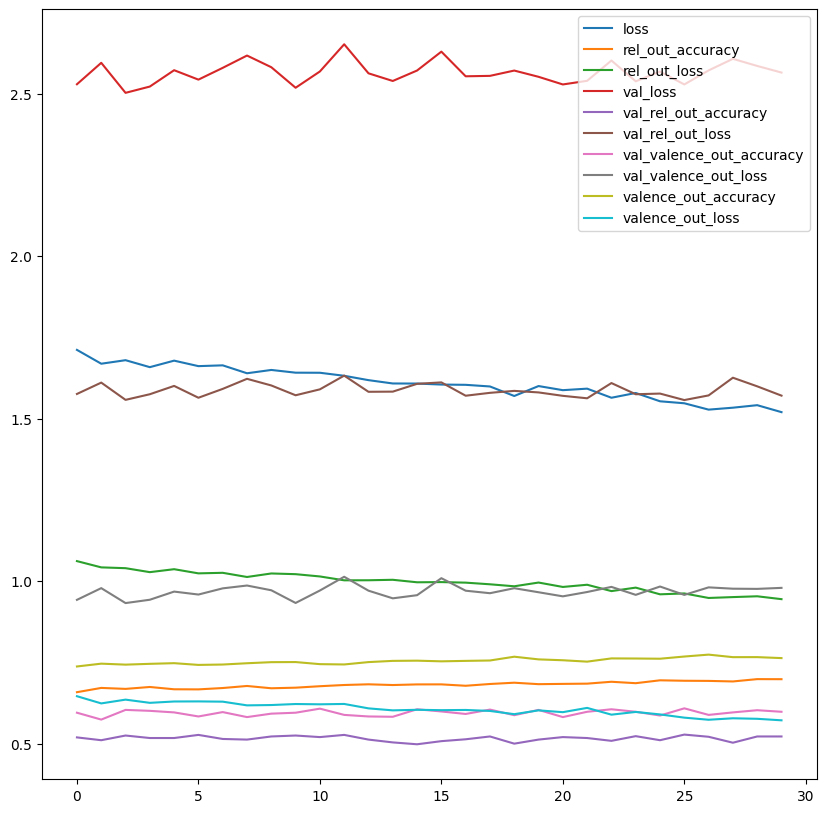

In [ ]:
pd.DataFrame(vH.history).plot(figsize=(10,10))

In [ ]:
l_pos_embs_val = tf.convert_to_tensor(np.stack(val['l_pos_embs'].values))
r_pos_embs_val = tf.convert_to_tensor(np.stack(val['r_pos_embs'].values))
y_val = tf.convert_to_tensor(np.stack(val['rel_target'].values))
tokenized_sents_val = build_sentence_input(val["sentence_text"].tolist())
vy_val = tf.convert_to_tensor(np.stack(val['Valence'].map(valence_targets).values))
tokenized_contexts_val = build_sentence_input(val["inner_context"].tolist())
cr_targets = {v:k for k,v in targets.items()}
val_targets = list(pd.Series(np.unique(y_val.numpy())).map(cr_targets))

In [ ]:
valence_preds = valence_model.predict([dict(tokenized_sents_val), l_pos_embs_val, r_pos_embs_val, dict(tokenized_contexts_val)], batch_size=64)

104/104 ━━━━━━━━━━━━━━━━━━━━ 105s 561ms/step


In [ ]:
valence_model.save("/content/drive/MyDrive/Colab Data/candidate_models/valenced_re_integrated_att.keras")

Saving fine-tuned roberta models...
Saving keras model...


In [ ]:
m = keras.models.load_model("/content/drive/MyDrive/Colab Data/candidate_models/valenced_re_integrated_att.keras", compile=False)
m.summary()
lps = m.predict([dict(tokenized_sents_val), l_pos_embs_val, r_pos_embs_val, dict(tokenized_contexts_val)], batch_size=32)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Data/vire_fine_tuned/roberta_vire_embeddings.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Data/vire_fine_tuned/roberta_slice_vire_embeddings.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "valence_integrated_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (2, 100, 69, 128)           │           8,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute_1 (Permute)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ ?                           │      15,351,552 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (100, 768)                  │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ ?                           │      15,351,552 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (1, 256)                    │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (1, 256)                    │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (1, 256)                    │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rel_out (Dense)                      │ (1, 18)                     │           4,626 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (1, 256)                    │          70,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ valence_out (Dense)                  │ (1, 4)                      │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,100,246 (122.45 MB)

 Trainable params: 32,091,414 (122.42 MB)

 Non-trainable params: 8,832 (34.50 KB)

208/208 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step


In [ ]:
vp = valence_preds['valence_out'].argmax(axis=1)
rp = valence_preds['rel_out'].argmax(axis=1)

lvp = lps['valence_out'].argmax(axis=1)
lrp = lps['rel_out'].argmax(axis=1)

print(classification_report(y_val.numpy(), rp, target_names=val_targets))
print(classification_report(vy_val.numpy(), vp, target_names=list(valence_targets.keys())))
print(classification_report(y_val.numpy(), lrp, target_names=val_targets))
print(classification_report(vy_val.numpy(), lvp, target_names=list(valence_targets.keys())))

              precision    recall  f1-score   support

     Present       0.56      0.49      0.52       394
        none       0.75      0.84      0.79      3160
     Belongs       0.55      0.44      0.49       416
          Is       0.62      0.62      0.62       691
      Agrees       0.54      0.48      0.51       126
      Caused       0.52      0.34      0.41       179
    MovesFor       0.51      0.47      0.49       245
     Opposes       0.55      0.54      0.54       242
     Informs       0.52      0.51      0.51       205
      Thinks       0.54      0.20      0.29        66
       Harms       0.58      0.71      0.64       221
       Kills       0.73      0.72      0.73        68
  Influences       0.56      0.64      0.59       259
       IsNot       0.53      0.33      0.41        72
     Obtains       0.44      0.11      0.18        61
   Disagrees       0.58      0.32      0.41        69
  Cooperates       0.68      0.24      0.36        79
      Threat       0.76    

In [ ]:
cv_targets = {v:k for k, v in valence_targets.items()}

In [ ]:
val['pred_rel'] = lrp
val['pred_rel'] = val['pred_rel'].map(cr_targets)
val['pred_val'] = lvp
val['pred_val'] = val['pred_val'].map(cv_targets)
val.sort_values(by='sid')[["sid","sentence_text","lefttext","righttext","Relation", "Valence","pred_rel", "pred_val"]].head(300)

,sid,sentence_text,lefttext,righttext,Relation,Valence,pred_rel,pred_val
47,1003.0,"[Thomas, Kroenke, has, travelled, with, Matt, ...",Thomas | Kroenke,NYC,MovesFor,Neutral,none,Neutral
1987,1003.0,"[Thomas, Kroenke, has, travelled, with, Matt, ...",Goeorge | Lincoln | Rockwell,NYC,Present,Neutral,none,none
6172,1003.0,"[Thomas, Kroenke, has, travelled, with, Matt, ...",Goeorge | Lincoln | Rockwell,Matt | Hale,none,none,none,Neutral
5788,1004.0,"[The, reverend, poignantly, told, me, of, the,...",kids,negroes,none,none,Harms,Negative
2406,1004.0,"[The, reverend, poignantly, told, me, of, the,...",negroes,White | kids,Harms,Negative,Harms,Negative
4200,1004.0,"[The, reverend, poignantly, told, me, of, the,...",negroes,kids,Harms,Negative,Harms,Negative
2610,1004.0,"[The, reverend, poignantly, told, me, of, the,...",heroin,reverend,none,none,none,none
2871,1004.0,"[The, reverend, poignantly, told, me, of, the,...",White | kids,heroin,none,none,Harms,Negative
2731,1004.0,"[The, reverend, poignantly, told, me, of, the,...",reverend,negroes,none,none,none,none
5870,1004.0,"[The, reverend, poignantly, told, me, of, the,...",reverend,private | investigator,Is,Neutral,none,none


In [ ]:
val[["sid", "lefttkids", "righttkids", "sentence_text",
     "left_entity", "lefttext","right_entity" ,"righttext",
     "Relation", "Valence", "pred_rel", "pred_val"]].to_csv("/content/drive/MyDrive/Colab Data/candidate_models/vre_predictions_3_25_25.csv", index=False)